Training LinearNet...
Training MLP...
Training CNN...


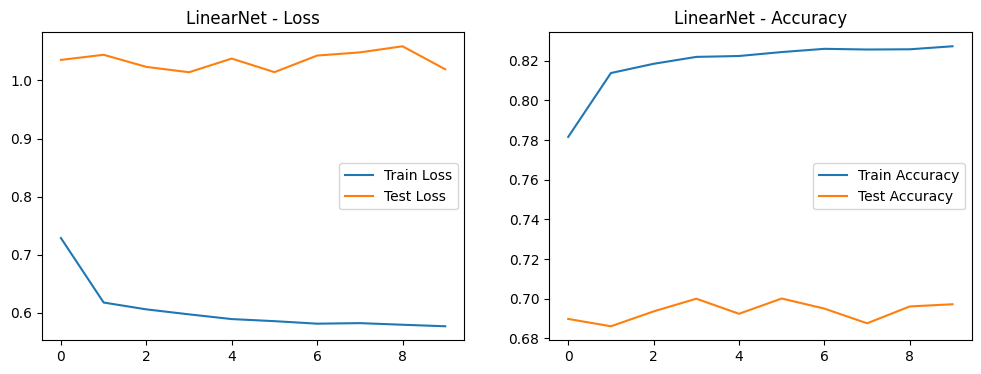

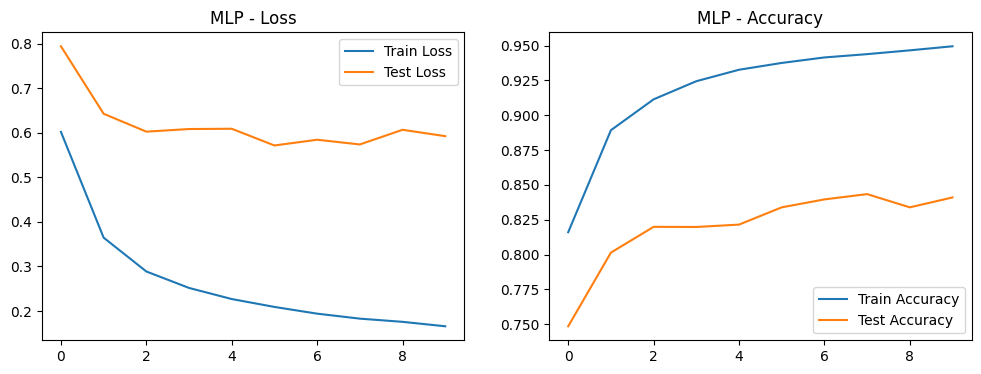

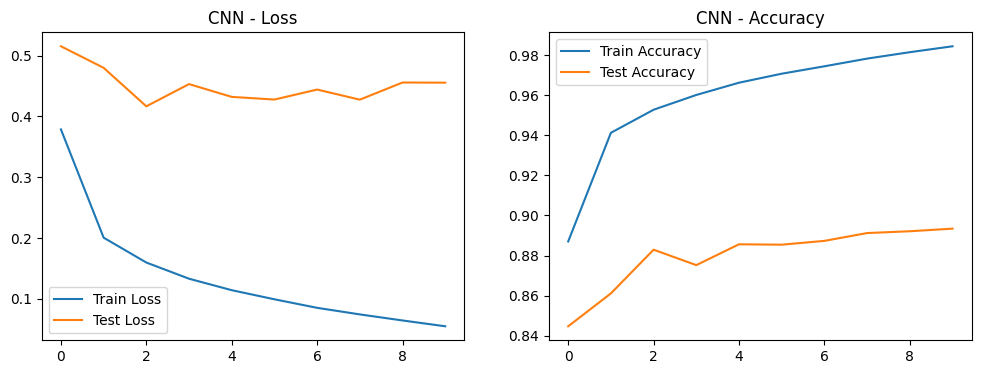

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Загрузка и предобработка данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Архитектуры сетей
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(28*28, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear(x)
        return x

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden = nn.Linear(28*28, 40)
        self.output = nn.Linear(40, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.hidden(x))
        x = self.output(x)
        return x

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32*14*14, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

# Обучение и оценка
def train_model(model, train_loader, test_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_losses.append(train_loss/len(train_loader))
        train_accs.append(correct/total)

        model.eval()
        test_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_losses.append(test_loss/len(test_loader))
        test_accs.append(correct/total)

    return train_losses, test_losses, train_accs, test_accs

# Обучение всех моделей
models = {
    "LinearNet": LinearNet(),
    "MLP": MLP(),
    "CNN": CNN()
}

results = {}
for name, model in models.items():
    print(f"Training {name}...")
    results[name] = train_model(model, train_loader, test_loader)

# Визуализация
for name in models.keys():
    train_losses, test_losses, train_accs, test_accs = results[name]
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title(f'{name} - Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(test_accs, label='Test Accuracy')
    plt.title(f'{name} - Accuracy')
    plt.legend()
    plt.show()